In [1]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np
from src.analysis.optimizers_results_schemas import (
    BayesianOptimizerResults,
    DifferentialEvolutionResults,
)
from src.analysis.analysis_utils import (
    generate_dict,
    populate_optimizer_results,
)

import matplotlib.pyplot as plt
import seaborn as sns

# plt.style.use("seaborn-whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

In [2]:
%matplotlib inline

In [3]:
DE_RESULTS_DIR = (
    "/Users/aalbustami/Ali/PID-Tuning-for-Motion-Optimization/DE-results"
)
BO_RESULTS_DIR = (
    "/Users/aalbustami/Ali/PID-Tuning-for-Motion-Optimization/BO-results"
)

In [4]:
CONFIGS = [f"config_{i}" for i in range(1, 4)]
TRIALS = [f"trial_{i}" for i in range(1, 2)]
INIT_FILES = ["csv", "txt"]

de_dict = generate_dict(CONFIGS, TRIALS, INIT_FILES)
bo_dict = generate_dict(CONFIGS, TRIALS, INIT_FILES)

In [5]:
de_dict = populate_optimizer_results(
    optimizer_results=DE_RESULTS_DIR, empty_dict=de_dict
)
bo_dict = populate_optimizer_results(
    optimizer_results=BO_RESULTS_DIR, empty_dict=bo_dict
)

In [6]:
de_results = DifferentialEvolutionResults(**de_dict)
bo_results = BayesianOptimizerResults(**bo_dict)

# Research Question 1: What is the propensity of BO and DE optimization algorithms to end up in local optima?

In [7]:
header = ["Optimizer", "# Trapped", "# Trials", "Convergence %"]

rows = [
    [
        "Bayesian Optimizer",
        bo_results.non_converging_count,
        bo_results.trials_count,
        np.round(
            (
                (bo_results.trials_count - bo_results.non_converging_count)
                / bo_results.trials_count
            )
            * 100,
            2,
        ),
    ],
    [
        "Differential Evolution",
        de_results.non_converging_count,
        de_results.trials_count,
        np.round(
            (
                (de_results.trials_count - de_results.non_converging_count)
                / de_results.trials_count
            )
            * 100,
            2,
        ),
    ],
]


fig = go.Figure(
    data=[
        go.Table(
            header=dict(
                values=header, fill_color="paleturquoise", align="left"
            ),
            cells=dict(
                values=list(zip(*rows)), fill_color="lavender", align="left"
            ),
        )
    ]
)

fig.show()

In [8]:
header = [
    "Optimizer",
    "Configuration",
    "# trapped",
    "# trials",
    "Convergence %",
]

rows = []

CONFIGS_NAMES = ["balanced", "exploration", "exploitation"]
for trial_index in range(1, 2):
    for config_index, config in enumerate(
        [
            bo_results.config_1,
            bo_results.config_2,
            bo_results.config_3,
        ]
    ):
        trial = config.trial_1
        rows.append(
            [
                "Bayesian Optimizer",
                CONFIGS_NAMES[config_index],
                trial.non_converging_count,
                trial.trials_count,
                np.round(
                    (
                        (trial.trials_count - trial.non_converging_count)
                        / trial.trials_count
                    ),
                    4,
                )
                * 100,
            ]
        )

    for config_index, config in enumerate(
        [
            de_results.config_1,
            de_results.config_2,
            de_results.config_3,
        ]
    ):
        trial = config.trial_1
        rows.append(
            [
                "Differential Evolution",
                CONFIGS_NAMES[config_index],
                trial.non_converging_count,
                trial.trials_count,
                np.round(
                    (
                        (trial.trials_count - trial.non_converging_count)
                        / trial.trials_count
                    ),
                    4,
                )
                * 100,
            ]
        )


fig = go.Figure(
    data=[
        go.Table(
            header=dict(
                values=header, fill_color="paleturquoise", align="left"
            ),
            cells=dict(
                values=list(zip(*rows)), fill_color="lavender", align="left"
            ),
        )
    ]
)

fig.show()

# Research Question 2:  What is the impact of the initail state on the optimizers convergence speed, settling time, and optimal gain values ($K_p$, $K_i$, $K_d$)

# RQ3. How do adjustments in the exploration-exploitation balance affect the optimizers' convergence speed, steady-state error, and settling time?

## Configuration 1: Balanced Exploration-Exploitation

In [9]:
header = [
    "Initial State",
    "Optimizer",
    "Time (s)",
    "# Iterations",
    "Settling Time (ms)",
    "Steady State Error %",
    "Kp",
    "Ki",
    "Kd",
]

rows = []

for init_index in range(6):
    # Loop for Bayesian Optimizer
    for config in [bo_results.config_1]:
        trial = config.trial_1
        init_txt = getattr(trial, f"init_{init_index}_txt")
        init_csv = getattr(trial, f"init_{init_index}_csv")
        if init_txt is not None:
            set_point = init_csv["set_point"].values[0]
            rows.append(
                [
                    init_txt.selected_init_state,
                    "Bayesian Optimizer",
                    init_txt.total_exp_time,
                    init_txt.n_trials,
                    init_txt.settling_time,
                    eval(init_csv["angle_values"].values[-1])[-1] - set_point,
                    init_txt.x.Kp,
                    init_txt.x.Ki,
                    init_txt.x.Kd,
                ]
            )
        else:
            rows.append(
                [
                    init_index,
                    "Bayesian Optimizer",
                    "didn't converge",
                    "150",
                    "didn't converge",
                    "didn't converge",
                    "didn't converge",
                    "didn't converge",
                    "didn't converge",
                ]
            )

    for config in [de_results.config_3]:
        trial = config.trial_1
        init_txt = getattr(trial, f"init_{init_index}_txt")
        init_csv = getattr(trial, f"init_{init_index}_csv")
        if init_txt is not None:
            set_point = init_csv["set_point"].values[0]
            rows.append(
                [
                    init_txt.selected_init_state,
                    "Differential Evolution",
                    init_txt.total_exp_time,
                    init_txt.n_trials,
                    init_txt.settling_time,
                    eval(init_csv["angle_values"].values[-1])[-1] - set_point,
                    init_txt.x.Kp,
                    init_txt.x.Ki,
                    init_txt.x.Kd,
                ]
            )
        else:
            rows.append(
                [
                    init_index,
                    "Bayesian Optimizer",
                    "didn't converge",
                    "150",
                    "didn't converge",
                    "didn't converge",
                    "didn't converge",
                    "didn't converge",
                    "didn't converge",
                ]
            )

fig = go.Figure(
    data=[
        go.Table(
            header=dict(
                values=header, fill_color="paleturquoise", align="left"
            ),
            cells=dict(
                values=list(zip(*rows)), fill_color="lavender", align="left"
            ),
        )
    ]
)

fig.show()


df_balanced = pd.DataFrame(rows, columns=header)
de_settling_time_balanced = df_balanced[
    df_balanced["Optimizer"] == "Differential Evolution"
]["Settling Time (ms)"].values
de_settling_time_balanced = de_settling_time_balanced[
    de_settling_time_balanced != "didn't converge"
]

bo_settling_time_balanced = df_balanced[
    df_balanced["Optimizer"] == "Bayesian Optimizer"
]["Settling Time (ms)"].values
bo_settling_time_balanced = bo_settling_time_balanced[
    bo_settling_time_balanced != "didn't converge"
]

de_sse_balanced = df_balanced[
    df_balanced["Optimizer"] == "Differential Evolution"
]["Steady State Error %"].values
de_sse_balanced = de_sse_balanced[de_sse_balanced != "didn't converge"]
bo_sse_balanced = df_balanced[
    df_balanced["Optimizer"] == "Bayesian Optimizer"
]["Steady State Error %"].values
bo_sse_balanced = bo_sse_balanced[bo_sse_balanced != "didn't converge"]

## Configuration 2: Exploration-Focused

In [10]:
header = [
    "Initial State",
    "Optimizer",
    "Time (s)",
    "# Iterations",
    "Settling Time (ms)",
    "Steady State Error",
    "Kp",
    "Ki",
    "Kd",
]

rows = []

for init_index in range(6):
    # Loop for Bayesian Optimizer
    for config in [bo_results.config_2]:
        trial = config.trial_1
        init_txt = getattr(trial, f"init_{init_index}_txt")
        init_csv = getattr(trial, f"init_{init_index}_csv")
        if init_txt is not None:
            set_point = init_csv["set_point"].values[0]
            rows.append(
                [
                    init_txt.selected_init_state,
                    "Bayesian Optimizer",
                    init_txt.total_exp_time,
                    init_txt.n_trials,
                    init_txt.settling_time,
                    eval(init_csv["angle_values"].values[-1])[-1] - set_point,
                    init_txt.x.Kp,
                    init_txt.x.Ki,
                    init_txt.x.Kd,
                ]
            )
        else:
            rows.append(
                [
                    init_index,
                    "Bayesian Optimizer",
                    "didn't converge",
                    "150",
                    "didn't converge",
                    "didn't converge",
                    "didn't converge",
                    "didn't converge",
                    "didn't converge",
                ]
            )

    for config in [de_results.config_1]:
        trial = config.trial_1
        init_txt = getattr(trial, f"init_{init_index}_txt")
        init_csv = getattr(trial, f"init_{init_index}_csv")
        if init_txt is not None:
            set_point = init_csv["set_point"].values[0]
            rows.append(
                [
                    init_txt.selected_init_state,
                    "Differential Evolution",
                    init_txt.total_exp_time,
                    init_txt.n_trials,
                    init_txt.settling_time,
                    eval(init_csv["angle_values"].values[-1])[-1] - set_point,
                    init_txt.x.Kp,
                    init_txt.x.Ki,
                    init_txt.x.Kd,
                ]
            )

fig = go.Figure(
    data=[
        go.Table(
            header=dict(
                values=header, fill_color="paleturquoise", align="left"
            ),
            cells=dict(
                values=list(zip(*rows)), fill_color="lavender", align="left"
            ),
        )
    ]
)

fig.show()

df_exploration = pd.DataFrame(rows, columns=header)
de_settling_time_exploration = df_exploration[
    df_exploration["Optimizer"] == "Differential Evolution"
]["Settling Time (ms)"].values
de_settling_time_exploration = de_settling_time_exploration[
    de_settling_time_exploration != "didn't converge"
]

bo_settling_time_exploration = df_exploration[
    df_exploration["Optimizer"] == "Bayesian Optimizer"
]["Settling Time (ms)"].values
bo_settling_time_exploration = bo_settling_time_exploration[
    bo_settling_time_exploration != "didn't converge"
]

de_sse_exploration = df_exploration[
    df_exploration["Optimizer"] == "Differential Evolution"
]["Steady State Error"].values
de_sse_exploration = de_sse_exploration[de_sse_exploration != "didn't converge"]
bo_sse_exploration = df_exploration[
    df_exploration["Optimizer"] == "Bayesian Optimizer"
]["Steady State Error"].values
bo_sse_exploration = bo_sse_exploration[bo_sse_exploration != "didn't converge"]

## Configuration 3: Exploitation-Focused

In [11]:
header = [
    "Initial State",
    "Optimizer",
    "Time (s)",
    "# Iterations",
    "Settling Time (ms)",
    "Steady State Error",
    "Kp",
    "Ki",
    "Kd",
]

rows = []

for init_index in range(6):
    for config in [bo_results.config_3]:
        trial = config.trial_1
        init_txt = getattr(trial, f"init_{init_index}_txt")
        init_csv = getattr(trial, f"init_{init_index}_csv")
        if init_txt is not None:
            set_point = init_csv["set_point"].values[0]
            rows.append(
                [
                    init_txt.selected_init_state,
                    "Bayesian Optimizer",
                    init_txt.total_exp_time,
                    init_txt.n_trials,
                    init_txt.settling_time,
                    eval(init_csv["angle_values"].values[-1])[-1] - set_point,
                    init_txt.x.Kp,
                    init_txt.x.Ki,
                    init_txt.x.Kd,
                ]
            )
        else:
            rows.append(
                [
                    init_index,
                    "Bayesian Optimizer",
                    "didn't converge",
                    "150",
                    "didn't converge",
                    "didn't converge",
                    "didn't converge",
                    "didn't converge",
                    "didn't converge",
                ]
            )

    for config in [de_results.config_2]:
        trial = config.trial_1
        init_txt = getattr(trial, f"init_{init_index}_txt")
        init_csv = getattr(trial, f"init_{init_index}_csv")
        if init_txt is not None:
            set_point = init_csv["set_point"].values[0]
            rows.append(
                [
                    init_txt.selected_init_state,
                    "Differential Evolution",
                    init_txt.total_exp_time,
                    init_txt.n_trials,
                    init_txt.settling_time,
                    eval(init_csv["angle_values"].values[-1])[-1] - set_point,
                    init_txt.x.Kp,
                    init_txt.x.Ki,
                    init_txt.x.Kd,
                ]
            )

fig = go.Figure(
    data=[
        go.Table(
            header=dict(
                values=header, fill_color="paleturquoise", align="left"
            ),
            cells=dict(
                values=list(zip(*rows)), fill_color="lavender", align="left"
            ),
        )
    ]
)

fig.show()

df_exploitation = pd.DataFrame(rows, columns=header)
de_settling_time_exploitation = df_exploitation[
    df_exploitation["Optimizer"] == "Differential Evolution"
]["Settling Time (ms)"].values
de_settling_time_exploitation = de_settling_time_exploitation[
    de_settling_time_exploitation != "didn't converge"
]

bo_settling_time_exploitation = df_exploitation[
    df_exploitation["Optimizer"] == "Bayesian Optimizer"
]["Settling Time (ms)"].values
bo_settling_time_exploitation = bo_settling_time_exploitation[
    bo_settling_time_exploitation != "didn't converge"
]

de_sse_exploitation = df_exploitation[
    df_exploitation["Optimizer"] == "Differential Evolution"
]["Steady State Error"].values
de_sse_exploitation = de_sse_exploitation[
    de_sse_exploitation != "didn't converge"
]

bo_sse_exploitation = df_exploitation[
    df_exploitation["Optimizer"] == "Bayesian Optimizer"
]["Steady State Error"].values
bo_sse_exploitation = bo_sse_exploitation[
    bo_sse_exploitation != "didn't converge"
]

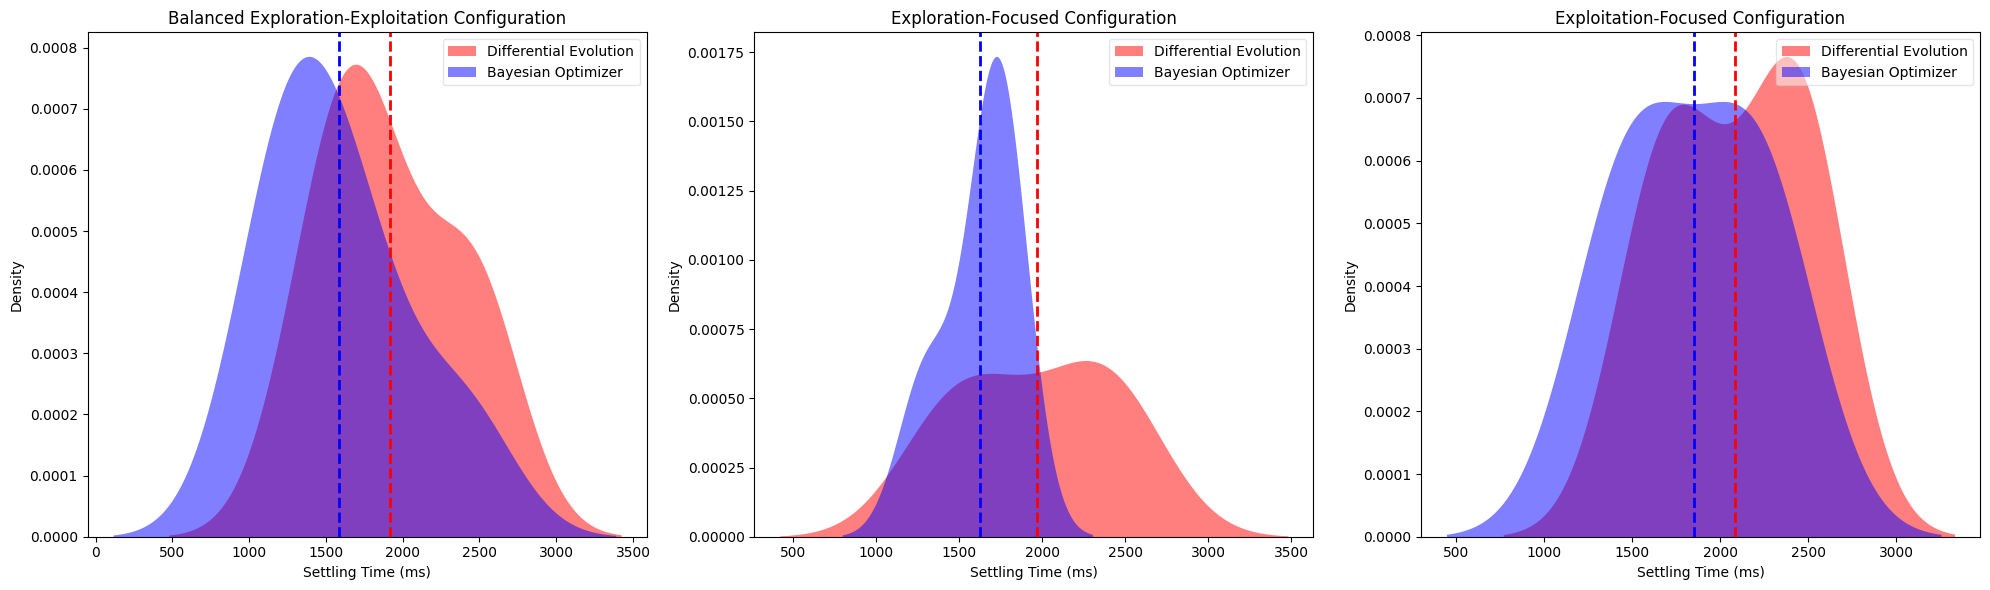

In [12]:
plt.figure(figsize=(20, 6))
plt.subplot(131)

sns.kdeplot(
    de_settling_time_balanced,
    color="red",
    label="Differential Evolution",
    fill=True,
    common_norm=False,
    alpha=0.5,
    linewidth=0,
)
sns.kdeplot(
    bo_settling_time_balanced,
    color="blue",
    label="Bayesian Optimizer",
    fill=True,
    common_norm=False,
    alpha=0.5,
    linewidth=0,
)

plt.title("Balanced Exploration-Exploitation Configuration")
plt.ylabel("Density")
plt.xlabel("Settling Time (ms)")
plt.axvline(
    np.mean(de_settling_time_balanced),
    color="red",
    linestyle="dashed",
    linewidth=2,
)
plt.axvline(
    np.mean(bo_settling_time_balanced),
    color="blue",
    linestyle="dashed",
    linewidth=2,
)
plt.legend(fancybox=True, framealpha=0.5)

plt.subplot(132)

sns.kdeplot(
    de_settling_time_exploration,
    color="red",
    label="Differential Evolution",
    fill=True,
    common_norm=False,
    alpha=0.5,
    linewidth=0,
)
sns.kdeplot(
    bo_settling_time_exploration,
    color="blue",
    label="Bayesian Optimizer",
    fill=True,
    common_norm=False,
    alpha=0.5,
    linewidth=0,
)

plt.title("Exploration-Focused Configuration")
plt.ylabel("Density")
plt.xlabel("Settling Time (ms)")
plt.axvline(
    np.mean(de_settling_time_exploration),
    color="red",
    linestyle="dashed",
    linewidth=2,
)
plt.axvline(
    np.mean(bo_settling_time_exploration),
    color="blue",
    linestyle="dashed",
    linewidth=2,
)
plt.legend(fancybox=True, framealpha=0.5)


plt.subplot(133)

sns.kdeplot(
    de_settling_time_exploitation,
    color="red",
    label="Differential Evolution",
    fill=True,
    common_norm=False,
    alpha=0.5,
    linewidth=0,
)
sns.kdeplot(
    bo_settling_time_exploitation,
    color="blue",
    label="Bayesian Optimizer",
    fill=True,
    common_norm=False,
    alpha=0.5,
    linewidth=0,
)

plt.title("Exploitation-Focused Configuration")
plt.ylabel("Density")
plt.xlabel("Settling Time (ms)")
plt.axvline(
    np.mean(de_settling_time_exploitation),
    color="red",
    linestyle="dashed",
    linewidth=2,
)
plt.axvline(
    np.mean(bo_settling_time_exploitation),
    color="blue",
    linestyle="dashed",
    linewidth=2,
)

plt.legend(fancybox=True, framealpha=0.5)
plt.tight_layout()
# plt.savefig("settling_time.png", dpi=1500)
plt.savefig("settling_time_low_res.png", dpi=150)
plt.show()

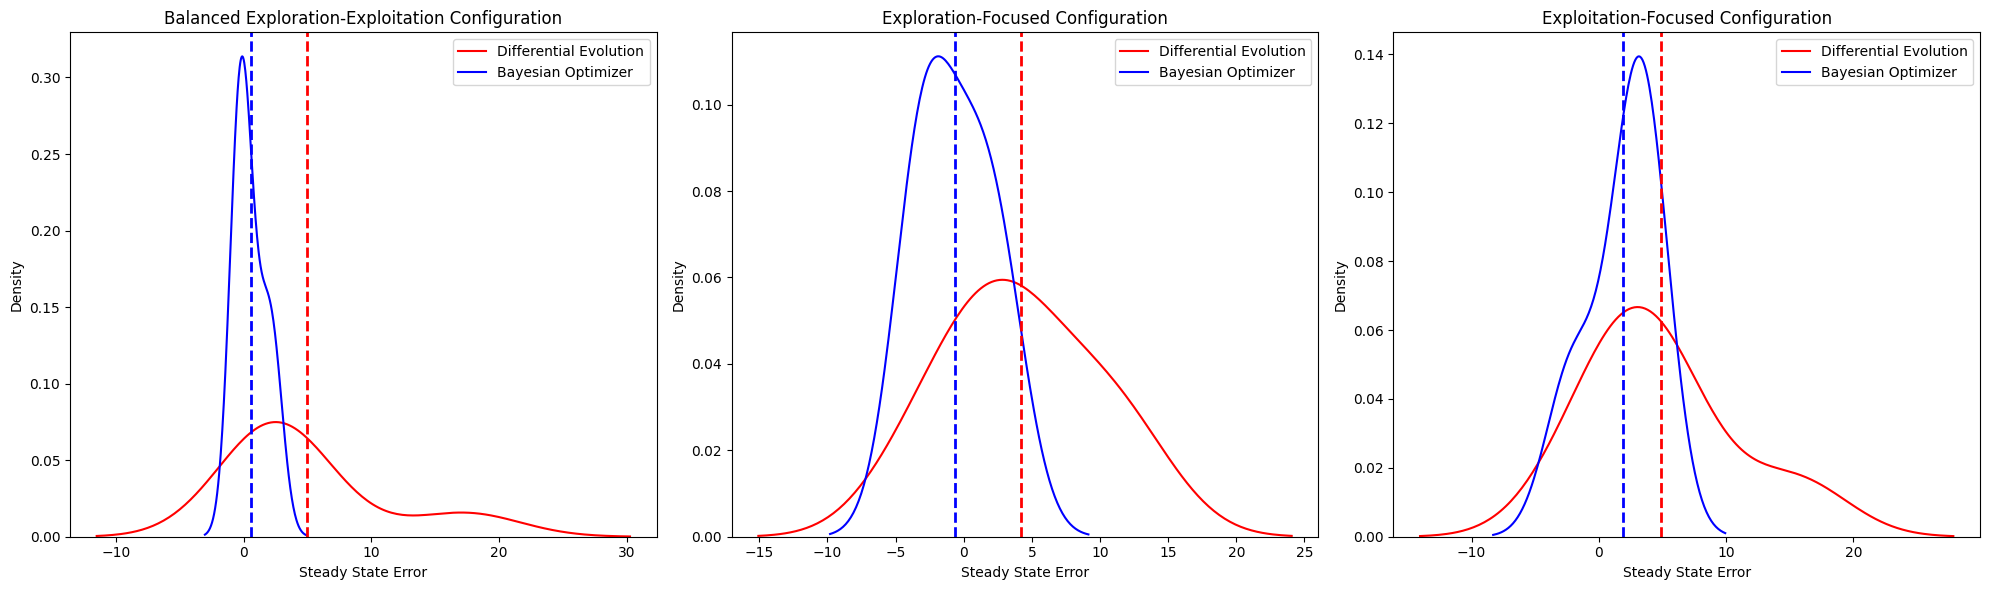

In [13]:
plt.figure(figsize=(20, 6))
plt.subplot(131)


sns.kdeplot(de_sse_balanced, label="Differential Evolution", color="red")
sns.kdeplot(bo_sse_balanced, label="Bayesian Optimizer", color="blue")
plt.xlabel("Steady State Error")
plt.ylabel("Density")
plt.axvline(
    np.mean(de_sse_balanced), color="red", linestyle="dashed", linewidth=2
)
plt.axvline(
    np.mean(bo_sse_balanced), color="blue", linestyle="dashed", linewidth=2
)
plt.title("Balanced Exploration-Exploitation Configuration")
plt.legend()

plt.subplot(132)

sns.kdeplot(de_sse_exploration, label="Differential Evolution", color="red")
sns.kdeplot(bo_sse_exploration, label="Bayesian Optimizer", color="blue")
plt.xlabel("Steady State Error")
plt.ylabel("Density")
plt.axvline(
    np.mean(de_sse_exploration), color="red", linestyle="dashed", linewidth=2
)
plt.axvline(
    np.mean(bo_sse_exploration), color="blue", linestyle="dashed", linewidth=2
)
plt.title("Exploration-Focused Configuration")
plt.legend()

plt.subplot(133)

sns.kdeplot(de_sse_exploitation, label="Differential Evolution", color="red")
sns.kdeplot(bo_sse_exploitation, label="Bayesian Optimizer", color="blue")
plt.xlabel("Steady State Error")
plt.ylabel("Density")
plt.axvline(
    np.mean(de_sse_exploitation), color="red", linestyle="dashed", linewidth=2
)
plt.axvline(
    np.mean(bo_sse_exploitation), color="blue", linestyle="dashed", linewidth=2
)
plt.title("Exploitation-Focused Configuration")
plt.legend()
plt.tight_layout()
# plt.savefig("steady_state_error.png", dpi=1500)
plt.savefig("steady_state_error_low_res.png", dpi=150)
plt.show()